In [5]:
!pip install -q pandas matplotlib seaborn scipy


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [14]:
import os
import pandas as pd

# Directory containing the data
data_directory = "/workspace/slice-monorepo/paper_analysis_upgrades/lr_csvs"

# Output file for the summary
output_file = "data_summary.txt"

# Initialize a set to store unique summaries
unique_summaries = set()
files_processed = 0  # To track the number of processed files

# Function to summarize a CSV file
def summarize_csv(file_path):
    try:
        # Load the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Get the column names and data types
        summary = f"File: {file_path}\n"
        summary += "Columns and Data Types:\n"
        for col, dtype in df.dtypes.items():  # Updated to use items() instead of iteritems()
            summary += f"  {col}: {dtype}\n"
        
        # Create a hashable summary to track uniqueness
        summary_signature = (tuple(df.columns), tuple(df.dtypes))
        
        return summary, summary_signature
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")  # Print the error for debugging
        return None, None

# Function to traverse the directory and summarize the CSV files
def summarize_directory(directory):
    global files_processed
    with open(output_file, "w") as f_out:
        for root, dirs, files in os.walk(directory):
            for file in files:
                # Ensure we only process visible CSV files (excluding hidden files)
                if file.endswith(".csv") and not file.startswith('.'):
                    file_path = os.path.join(root, file)
                    
                    # Debug: Print file name to ensure script is running
                    if files_processed < 5:  # Limit the number of files printed for debugging
                        print(f"Processing file: {file_path}")
                    
                    summary, signature = summarize_csv(file_path)
                    
                    # Only write unique summaries to the output file
                    if signature and signature not in unique_summaries:
                        unique_summaries.add(signature)
                        f_out.write(summary + "\n")
                    
                    # Update progress
                    files_processed += 1
                    if files_processed % 100 == 0:
                        print(f"Processed {files_processed} files so far...")

# Run the summarization on the directory
summarize_directory(data_directory)

print(f"Data summary completed. Summary written to {output_file}. Total files processed: {files_processed}")


Processing file: /workspace/slice-monorepo/paper_analysis_upgrades/lr_csvs/sub_validations_learning_rate_studies_rare_memory_injections_rare_memory_injection_EleutherAI_pythia-160m_learning_rate_0.0005_inference_epoch_1.csv
Processing file: /workspace/slice-monorepo/paper_analysis_upgrades/lr_csvs/sub_validations_learning_rate_studies_rare_memory_injections_rare_memory_injection_EleutherAI_pythia-14m_learning_rate_5e-05_inference_epoch_5.csv
Processing file: /workspace/slice-monorepo/paper_analysis_upgrades/lr_csvs/sub_validations_learning_rate_studies_rare_memory_injections_rare_memory_injection_EleutherAI_pythia-410m_learning_rate_5e-05_inference_epoch_4.csv
Processing file: /workspace/slice-monorepo/paper_analysis_upgrades/lr_csvs/sub_validations_learning_rate_studies_rare_memory_injections_super_rare_memory_injection_EleutherAI_pythia-160m_learning_rate_1e-05_inference_results.csv
Processing file: /workspace/slice-monorepo/paper_analysis_upgrades/lr_csvs/sub_validations_learning_ra

=== Memory Retention Analysis ===
Learning Rate: 5e-06, Mean Correct: 15.88, Variance: 201.6562248995984
Learning Rate: 5e-05, Mean Correct: 65.592, Variance: 946.3067630522088
Learning Rate: 0.0005, Mean Correct: 30.212, Variance: 1044.376562248996
Learning Rate: 5e-06, Mean Correct: 15.88, Variance: 201.6562248995984
Learning Rate: 5e-05, Mean Correct: 65.592, Variance: 946.3067630522088
Learning Rate: 0.0005, Mean Correct: 30.212, Variance: 1044.376562248996


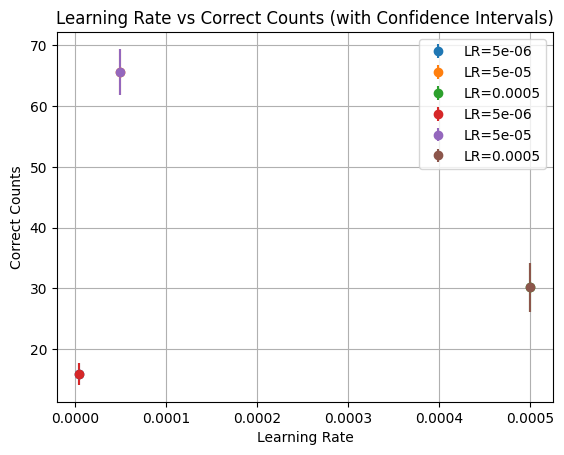

=== Generalization Analysis ===
Learning Rate: -1.406552966165575e-15, Transfer Ratio: NaN (Invalid Data)
Learning Rate: 1.317264962144304e-15, Transfer Ratio: NaN (Invalid Data)
Learning Rate: 2.4025978961050947e-15, Transfer Ratio: NaN (Invalid Data)
Learning Rate: -5.114322361004327e-15, Transfer Ratio: NaN (Invalid Data)
Learning Rate: 1.0, Transfer Ratio: NaN (Invalid Data)
Learning Rate: 3.963950754225186e-15, Transfer Ratio: NaN (Invalid Data)
Learning Rate: -0.067769187640295, Transfer Ratio: NaN (Invalid Data)
Learning Rate: 75000.0, Transfer Ratio: NaN (Invalid Data)
Learning Rate: 0.000185, Transfer Ratio: NaN (Invalid Data)
Learning Rate: 0.0002234964563676, Transfer Ratio: NaN (Invalid Data)
Learning Rate: 5e-06, Transfer Ratio: NaN (Invalid Data)
Learning Rate: 5e-05, Transfer Ratio: NaN (Invalid Data)
Learning Rate: 0.0005, Transfer Ratio: NaN (Invalid Data)
Learning Rate: 75000.0, Transfer Ratio: NaN (Invalid Data)
Learning Rate: 0.000185, Transfer Ratio: NaN (Invalid D

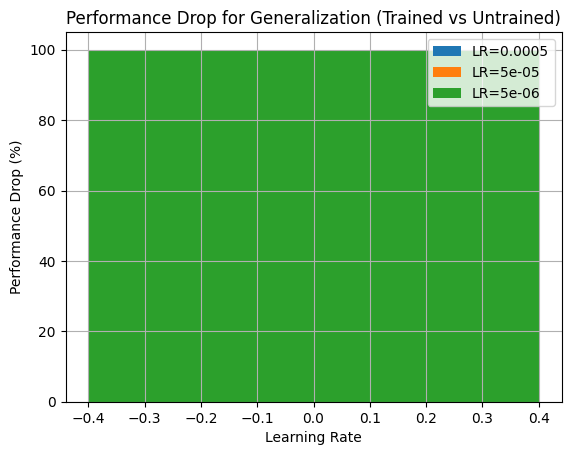

=== Noise Reduction Analysis ===
Pre-Training data is missing, skipping variance calculation for pre-training
Pre-Training Variance: nan, Post-Training Variance: 1165.9038878504673
Pre-Training data is missing, skipping variance calculation for pre-training
Pre-Training Variance: nan, Post-Training Variance: 1165.9038878504673


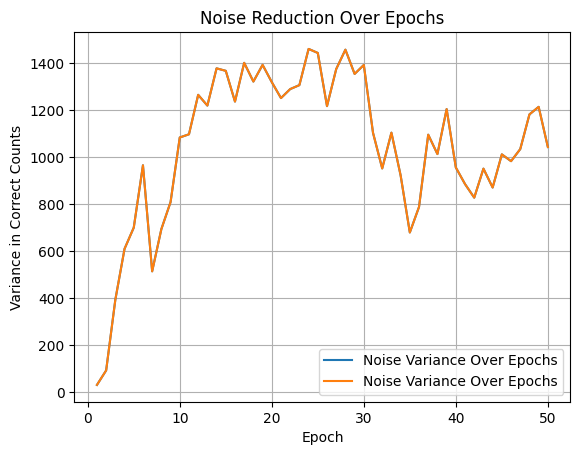

=== Memory Retention Consistency Analysis ===
Skipping file: missing 'correct_count' column
Skipping file: missing 'correct_count' column


/tmp/ipykernel_4309/3336810837.py:183: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


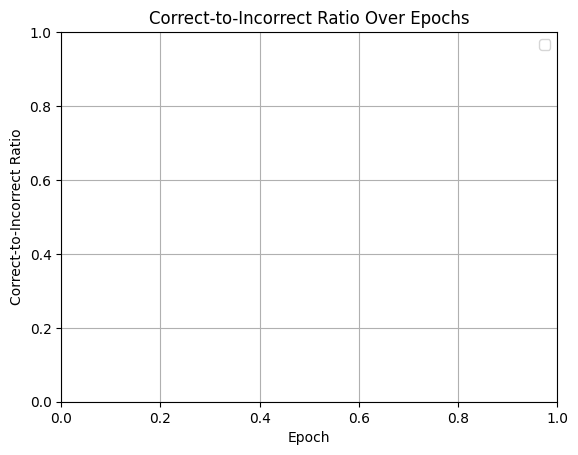

All analyses completed and visualizations saved.


In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Function to calculate confidence intervals
def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    stderr = stats.sem(data)
    interval = stderr * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, mean - interval, mean + interval

# Directory containing the data
data_directory = "/workspace/slice-monorepo/paper_analysis_upgrades/lr_csvs"

# Analysis output directory for saving plots
output_directory = "./analysis_results/"
os.makedirs(output_directory, exist_ok=True)

# Initialize data structures to store results
memory_retention_data = []
generalization_data = []
noise_reduction_data = []

# Step 1: Traverse the directory and read CSV files
def load_data():
    for root, dirs, files in os.walk(data_directory):
        for file in files:
            if file.endswith(".csv") and not file.startswith('.'):
                file_path = os.path.join(root, file)
                try:
                    df = pd.read_csv(file_path)
                    # Detect specific analyses based on file structure (columns)
                    if 'learning_rate' in df.columns and 'correct_sum' in df.columns:
                        memory_retention_data.append(df)
                    if 'correct' in df.columns and 'learning_rate' in df.columns:
                        generalization_data.append(df)
                    if 'epoch' in df.columns and 'correct_sum' in df.columns:
                        noise_reduction_data.append(df)
                except Exception as e:
                    print(f"Failed to read {file_path}: {e}")

# Step 2: Learning Rate vs. Memory Retention Analysis
def analyze_memory_retention(dataframes):
    print("=== Memory Retention Analysis ===")
    retention_results = []

    for df in dataframes:
        learning_rates = df['learning_rate'].unique()
        for lr in learning_rates:
            subset = df[df['learning_rate'] == lr]
            mean_correct = subset['correct_sum'].mean()
            var_correct = subset['correct_sum'].var()
            print(f"Learning Rate: {lr}, Mean Correct: {mean_correct}, Variance: {var_correct}")
            retention_results.append((lr, mean_correct, var_correct))

            # Plot Learning Rate vs Correct Sum with confidence intervals
            mean, ci_lower, ci_upper = calculate_confidence_interval(subset['correct_sum'])
            yerr = np.array([[mean - ci_lower], [ci_upper - mean]])

            if not np.isnan(mean):
                plt.errorbar([lr], [mean], yerr=yerr, fmt='o', label=f'LR={lr}')

    # Display the plot
    plt.title("Learning Rate vs Correct Counts (with Confidence Intervals)")
    plt.xlabel("Learning Rate")
    plt.ylabel("Correct Counts")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_directory, "memory_retention.png"))
    plt.show()

# Step 3: Generalization and Transferability Analysis
def analyze_generalization(dataframes):
    print("=== Generalization Analysis ===")
    generalization_results = []

    for df in dataframes:
        # Filter invalid learning rates and handle cases where correct counts may be missing
        df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['learning_rate'])
        learning_rates = df['learning_rate'].unique()
        
        for lr in learning_rates:
            subset = df[df['learning_rate'] == lr]

            # Handle cases where there are missing or NaN values for correct counts
            try:
                trained_accuracy = subset[subset['correct'] == True]['correct'].mean()
                untrained_accuracy = subset[subset['correct'] == False]['correct'].mean()

                if pd.isna(trained_accuracy) or pd.isna(untrained_accuracy):
                    print(f"Learning Rate: {lr}, Transfer Ratio: NaN (Invalid Data)")
                    continue

                transfer_ratio = untrained_accuracy / trained_accuracy if trained_accuracy != 0 else 0
                print(f"Learning Rate: {lr}, Transfer Ratio: {transfer_ratio}")
                generalization_results.append((lr, transfer_ratio))

                # Plot the performance drop for each learning rate
                performance_drop = 100 * (1 - transfer_ratio)
                if not np.isnan(performance_drop):
                    plt.bar(lr, performance_drop, label=f'LR={lr}')

            except ZeroDivisionError:
                print(f"Learning Rate: {lr}, Transfer Ratio: NaN (ZeroDivisionError)")
                continue

    # Display the plot
    plt.title("Performance Drop for Generalization (Trained vs Untrained)")
    plt.xlabel("Learning Rate")
    plt.ylabel("Performance Drop (%)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_directory, "generalization_transferability.png"))
    plt.show()

# Step 4: Noise Reduction and Learning Stability Analysis
def analyze_noise_reduction(dataframes):
    print("=== Noise Reduction Analysis ===")
    pre_post_results = []

    for df in dataframes:
        pre_training = df[df['epoch'] == 0]['correct_sum']
        post_training = df[df['epoch'] > 0]['correct_sum']

        # Check if pre-training data exists before calculating variance
        if pre_training.empty:
            print("Pre-Training data is missing, skipping variance calculation for pre-training")
            pre_variance = np.nan
        else:
            pre_variance = pre_training.var()

        post_variance = post_training.var() if not post_training.empty else np.nan

        print(f"Pre-Training Variance: {pre_variance}, Post-Training Variance: {post_variance}")
        pre_post_results.append((pre_variance, post_variance))

        # Plot noise reduction across epochs
        epochs = df['epoch'].unique()
        variance_per_epoch = [df[df['epoch'] == epoch]['correct_sum'].var() for epoch in epochs]
        plt.plot(epochs, variance_per_epoch, label="Noise Variance Over Epochs")

    # Display the plot
    plt.title("Noise Reduction Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Variance in Correct Counts")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_directory, "noise_reduction.png"))
    plt.show()

# Step 5: Memory Retention Consistency (Correct-to-Incorrect Ratios & Variability)
def analyze_memory_retention_consistency(dataframes):
    print("=== Memory Retention Consistency Analysis ===")
    consistency_results = []

    for df in dataframes:
        if 'correct_count' not in df.columns:
            print(f"Skipping file: missing 'correct_count' column")
            continue

        # Calculate correct-to-incorrect ratio and track variability over time (epochs)
        epochs = df['epoch'].unique()
        for epoch in epochs:
            subset = df[df['epoch'] == epoch]
            correct = subset['correct_count'].sum() if 'correct_count' in subset.columns else 0
            incorrect = len(subset) - correct
            ratio = correct / incorrect if incorrect != 0 else 0
            print(f"Epoch: {epoch}, Correct/Incorrect Ratio: {ratio}")
            consistency_results.append((epoch, ratio))

            # Plot the correct-to-incorrect ratio over epochs
            if ratio > 0:
                plt.plot(epoch, ratio, 'o', label=f'Epoch={epoch}')

    # Display the plot
    plt.title("Correct-to-Incorrect Ratio Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Correct-to-Incorrect Ratio")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_directory, "retention_consistency.png"))
    plt.show()

# Step 6: Execute All Analyses
def run_analysis():
    load_data()
    analyze_memory_retention(memory_retention_data)
    analyze_generalization(generalization_data)
    analyze_noise_reduction(noise_reduction_data)
    analyze_memory_retention_consistency(memory_retention_data)
    print("All analyses completed and visualizations saved.")

# Run the full analysis
run_analysis()


In [10]:
import os

# Root directory of the files
root_dir = "/workspace/slice-monorepo/sub_validations/learning_rate_studies/rare_memory_injections"
output_file = "combined_summary.txt"

# Function to extract code and summarize
def extract_code(file_path):
    summary = []
    try:
        # If it's a Python file
        if file_path.endswith('.py'):
            with open(file_path, 'r') as f:
                summary.append(f"\n# --- Content from: {file_path} --- #\n")
                summary.extend(f.readlines())
        # If it's a Jupyter Notebook file
        elif file_path.endswith('.ipynb'):
            import json
            with open(file_path, 'r') as f:
                summary.append(f"\n# --- Content from: {file_path} --- #\n")
                notebook = json.load(f)
                for cell in notebook['cells']:
                    if cell['cell_type'] == 'code':
                        summary.append('\n'.join(cell['source']))
                        summary.append("\n")
        return summary
    except Exception as e:
        return [f"\n# Error reading {file_path}: {str(e)}\n"]

# Main function to traverse the directory
def combine_code(root_dir, output_file):
    with open(output_file, 'w') as output:
        for dirpath, _, filenames in os.walk(root_dir):
            for filename in filenames:
                file_path = os.path.join(dirpath, filename)
                if file_path.endswith(('.py', '.ipynb')):
                    code_content = extract_code(file_path)
                    output.writelines(code_content)
    print(f"Combined code and summaries written to {output_file}")

# Execute the function
combine_code(root_dir, output_file)


Combined code and summaries written to combined_summary.txt
